# 02. Neural Network Classification with PyTorch

Classification is the problem of predicting whether something is one thing or another (there can be multiple things as options)



## 1. Make classification data and get it ready

In [1]:
import sklearn

from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
print(f"First 5 samples:\n{X[:5]}")
print(f"\nFirst 5 labels:\n{y[:5]}")

First 5 samples:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 labels:
[1 1 1 1 0]


In [3]:
# Make a dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0] , 
                        "X2": X[:, 1], 
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


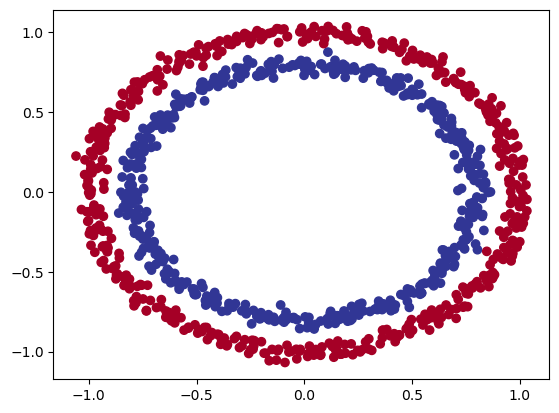

In [4]:
# Visualize, visualize, visualize  
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we are working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [5]:
# Input shapes:
print(f"X shape: {X.shape}")

# Output shapes:
print(f"y shape: {y.shape}")

X shape: (1000, 2)
y shape: (1000,)


In [6]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test sets

In [7]:
import torch
torch.__version__

'2.2.0'

In [8]:
X.dtype

dtype('float64')

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
# Split data into Training and Test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an acceleraotr if there is one
2. Construct a model (by subclassing the nn.Module)
3. Define a loss function and optimizer
4. Create a train and test loop

In [13]:
# Imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we have setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create two `nn.Linear()` layers, that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [14]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [15]:
# 1. Construct a model that subclasses the nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create two nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=5)
        self.layer_2 = nn.Linear(in_features=5,
                                 out_features=1)
        
    # 3. Define the forward method
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        return x

In [16]:
# 4. Instantiate an instance of our model and send it to the device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
# Let's replicate the model using nn.Sequential()
model_0 = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 1)
        ).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4508,  0.4999],
                      [ 0.0019, -0.6828],
                      [-0.4476,  0.3692],
                      [ 0.3866, -0.1040],
                      [-0.1016,  0.5825]])),
             ('0.bias', tensor([-0.2025,  0.4396,  0.1609, -0.0138,  0.5209])),
             ('1.weight',
              tensor([[-0.0030,  0.4451,  0.0639,  0.2357,  0.3119]])),
             ('1.bias', tensor([-0.2265]))])

In [19]:
# Make Predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
    print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[0.0418],
        [0.0201],
        [0.1553],
        [0.0094],
        [0.2453],
        [0.2314],
        [0.0990],
        [0.1487],
        [0.1513],
        [0.0196]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific

For example, for regression you might want to use MSE or MAE

For classification, you might want to use binary cross-entropy loss or categorical cross-entropy loss

In [20]:
# Setup the loss function
# loss_fn = nn.BCELoss() # Requires inputs to be between 0 and 1 (passed through sigmoid already)
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss with sigmoid function (inputs do not have to be between 0 and 1)

# BCEWithLogitsLoss = nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )

optimizer = torch.optim.SGD(params= model_0.parameters(),
                            lr=0.1)


In [21]:
# Calculate Accuracy
def accuracy_fn(y_true, y_pred):
    # torch.eq() returns a boolean value for every element of y_true and y_pred
    # .sum() adds up the number of True values
    # .item() gets the value out of the tensor
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_true)
    return acc*100

## 3. Train the model

To train our model, we are going to build a training loop:

1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probabilities** by passing them into some kind of activation function (e.g. `sigmoid` for binary classification or `softmax` for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [22]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0418],
        [0.0201],
        [0.1553],
        [0.0094],
        [0.2453]])

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

For our prediction probability values, we need to perform a range-style rounding on them:
`y_pred_probs` >= 0.5, `y = 1` (class 1)  
`y_pred_probs` < 0.5, `y = 0` (class 0)

In [24]:
# Use the sigmoid activation function to transform logits to prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5104],
        [0.5050],
        [0.5387],
        [0.5023],
        [0.5610]])

In [25]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred_probs -> pred_labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred_probs -> pred_labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) ## BCELoss
    loss = loss_fn(y_logits, ## BCEWithLogitsLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
    
    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Backprop
    loss.backward()

    # 5. Step (update)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print some results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Training Loss: {loss:.5f} | Training Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")
        

Epoch: 0 | Training Loss: 0.69709 | Training Accuracy: 50.00% | Test Loss: 0.69365 | Test Accuracy: 50.00%
Epoch: 10 | Training Loss: 0.69507 | Training Accuracy: 58.63% | Test Loss: 0.69259 | Test Accuracy: 60.50%
Epoch: 20 | Training Loss: 0.69417 | Training Accuracy: 52.88% | Test Loss: 0.69235 | Test Accuracy: 56.50%
Epoch: 30 | Training Loss: 0.69372 | Training Accuracy: 52.75% | Test Loss: 0.69239 | Test Accuracy: 54.00%
Epoch: 40 | Training Loss: 0.69348 | Training Accuracy: 52.00% | Test Loss: 0.69253 | Test Accuracy: 52.50%
Epoch: 50 | Training Loss: 0.69334 | Training Accuracy: 52.38% | Test Loss: 0.69270 | Test Accuracy: 52.50%
Epoch: 60 | Training Loss: 0.69325 | Training Accuracy: 51.88% | Test Loss: 0.69287 | Test Accuracy: 52.00%
Epoch: 70 | Training Loss: 0.69319 | Training Accuracy: 52.50% | Test Loss: 0.69303 | Test Accuracy: 55.50%
Epoch: 80 | Training Loss: 0.69315 | Training Accuracy: 50.00% | Test Loss: 0.69317 | Test Accuracy: 50.00%
Epoch: 90 | Training Loss: 0.

## 4. Make predictions and evaluate our model

From the metrics it looks like our model isnt learning anything

So to inspect it let's make some predictions and visualize them

In other words, "Visualize, visualize, visualize"

To do so, we're going to import a function called `plot_decision_boundary()` which will help us visualize the predictions our model is making

In [28]:
!pip install torchvision

In [29]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it is not already downloaded)
if Path("helper_functions.py").is_file():
    print("File already exists, skipping download.")
else:
    print("Downloading file...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

File already exists, skipping download.


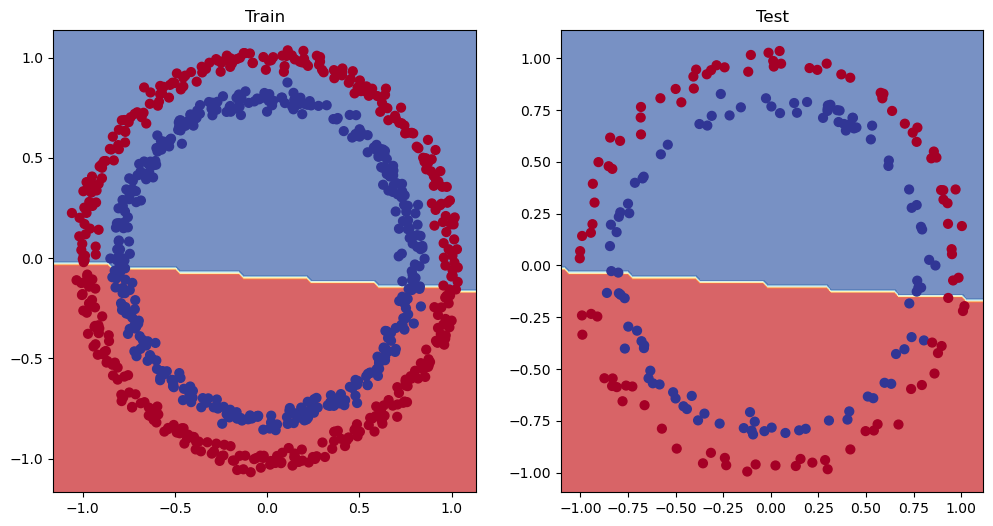

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_0,
                       X=X_train,
                       y=y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_0,
                       X=X_test,
                       y=y_test)

## 5. Improving a model (from a model's perspective)

- Add more layers - give the model more chances to learn about the patterns in the data
- Add more hidden units - go from 5 hidden units to 10 for example
- Fit for longer - Train longer 
- Changing the activation function
- Changing the learning rate
- Changing the loss function

These options are all from a model's perspective so they are all things you can change about the model itself

And because these options are all values that we can change about the model itself, they are often referred to as **hyperparameters**

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a large problem is to start with a smaller problem

In [31]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = (weight * X_regression + bias) 

# Check the data
print(len(X_regression), len(y_regression))
X_regression[:5], y_regression[:5]

100 100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [32]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the splits
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)


(80, 80, 20, 20)

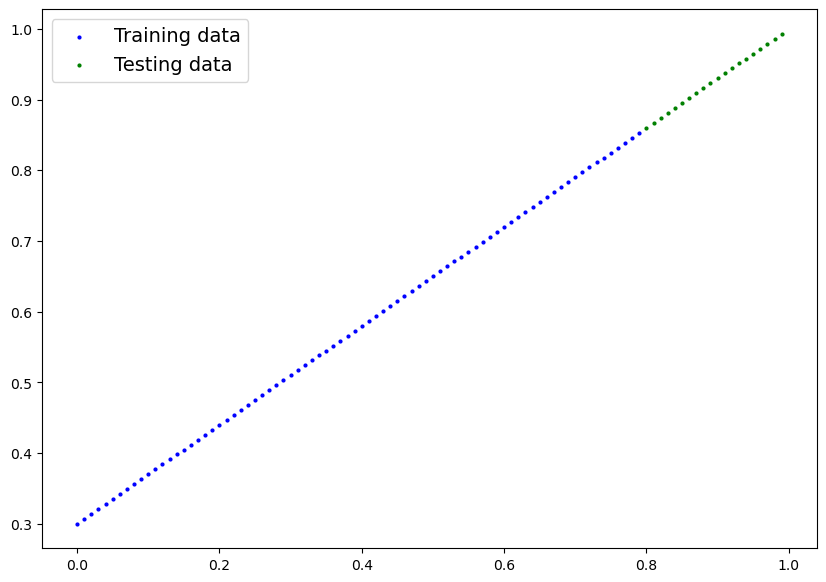

In [33]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression)


### 5.2 Adjusting `model_1`to fit a straight line

In [34]:
model_2 = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 10),
    nn.Linear(10, 1)
).to(device)

In [35]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [36]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Build training loop
for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_loss = loss_fn(model_2(X_test_regression), y_test_regression)

    # Print some results
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Training Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


Epoch: 0 | Training Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Training Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Training Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Training Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Training Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Training Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Training Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Training Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Training Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Training Loss: 0.01798 | Test Loss: 0.00360


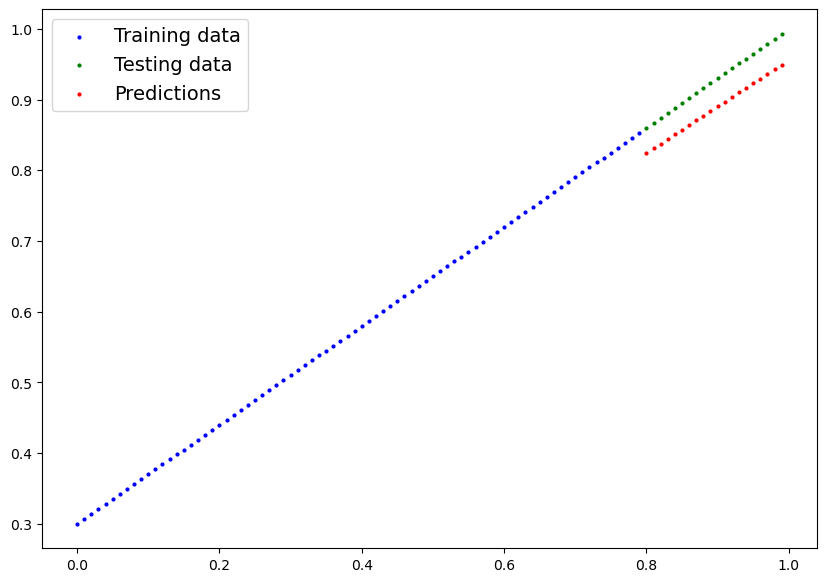

In [39]:
# Plot predictions
model_2.eval()
with torch.inference_mode():
    y_preds_regression = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds_regression.cpu())

## 6. The missing piece: Non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in ML terms, an infinite amount of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

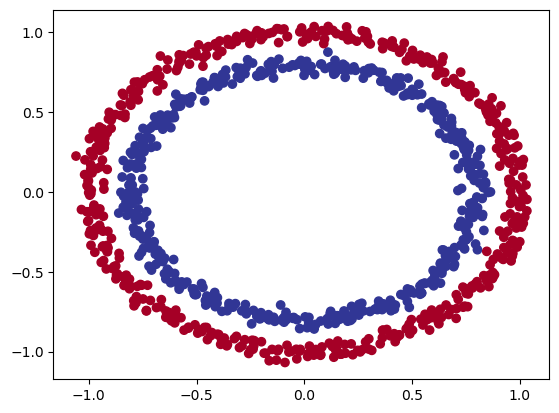

In [52]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [53]:
# Convert data to tensors and split into training and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [74]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [75]:
model_3 = CircleModelV1().to(device)
model_3

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [76]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [77]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 2000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Train the model
for epoch in range(epochs):
    model_3.train()

    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Step (update)
    optimizer.step()

    # Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # Print some results
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Training Loss: {loss:.5f} | Training Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Training Loss: 0.69295 | Training Accuracy: 50.00% | Test Loss: 0.69319 | Test Accuracy: 50.00%
Epoch: 100 | Training Loss: 0.69115 | Training Accuracy: 52.88% | Test Loss: 0.69102 | Test Accuracy: 52.50%
Epoch: 200 | Training Loss: 0.68977 | Training Accuracy: 53.37% | Test Loss: 0.68940 | Test Accuracy: 55.00%
Epoch: 300 | Training Loss: 0.68795 | Training Accuracy: 53.00% | Test Loss: 0.68723 | Test Accuracy: 56.00%
Epoch: 400 | Training Loss: 0.68517 | Training Accuracy: 52.75% | Test Loss: 0.68411 | Test Accuracy: 56.50%
Epoch: 500 | Training Loss: 0.68102 | Training Accuracy: 52.75% | Test Loss: 0.67941 | Test Accuracy: 56.50%
Epoch: 600 | Training Loss: 0.67515 | Training Accuracy: 54.50% | Test Loss: 0.67285 | Test Accuracy: 56.00%
Epoch: 700 | Training Loss: 0.66659 | Training Accuracy: 58.38% | Test Loss: 0.66322 | Test Accuracy: 59.00%
Epoch: 800 | Training Loss: 0.65160 | Training Accuracy: 64.00% | Test Loss: 0.64757 | Test Accuracy: 67.50%
Epoch: 900 | Training

### 6.4 Evaluating a model with non-linearity

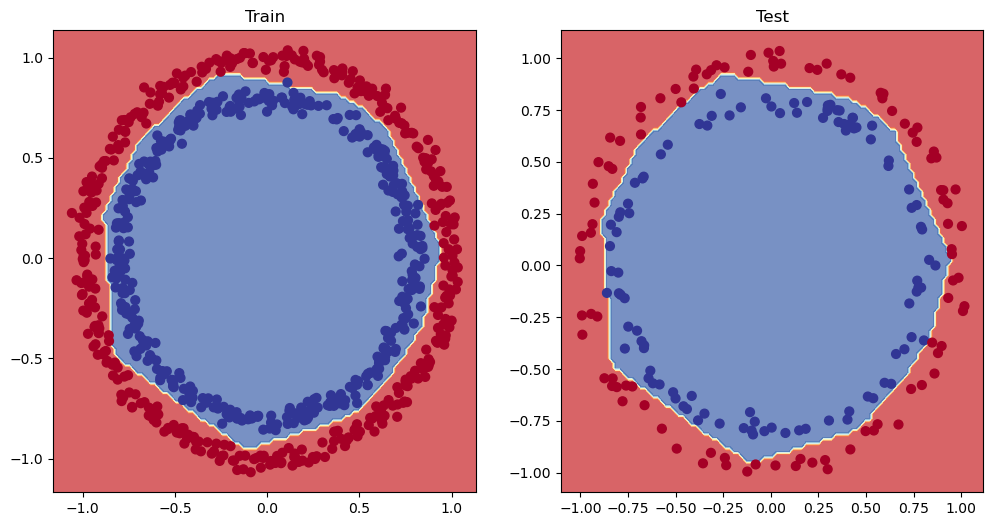

In [78]:
model_3.eval()
with torch.inference_mode():
    y_preds = model_3(X_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_3,
                        X=X_train,
                        y=y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_3,
                        X=X_test,
                        y=y_test)


## 7. Replicating non-linear activation functions

NN, rather than us telling the model what to learn, we give it the tools to discover patterns in the data and it tries to figure out the best patterns on its own.

And these tools are linear and non-linear functions.

In [79]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float)

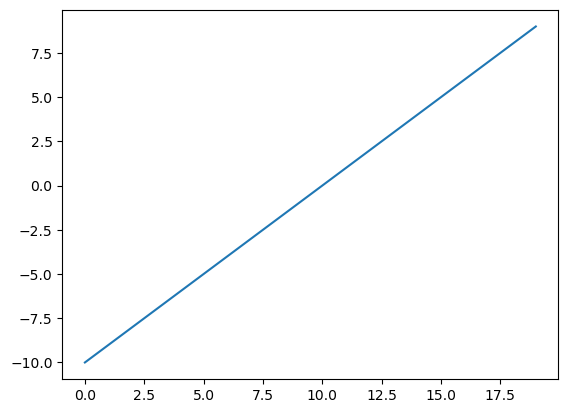

In [82]:
# Visualize
plt.plot(A)

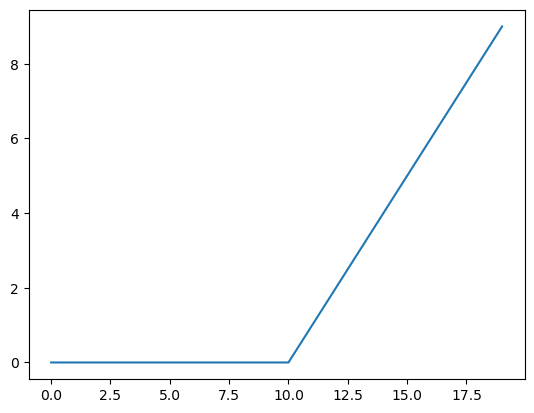

In [83]:
plt.plot(torch.relu(A))

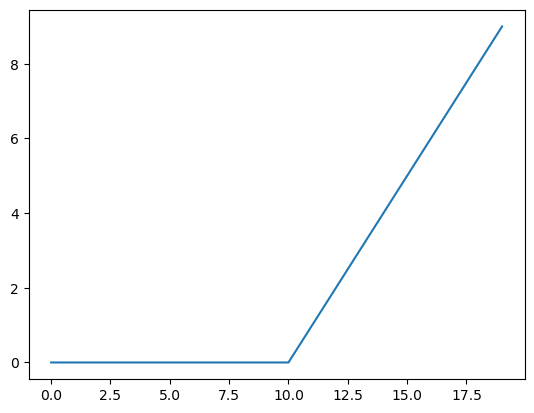

In [85]:
def relu(X: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), X)

plt.plot(relu(A))

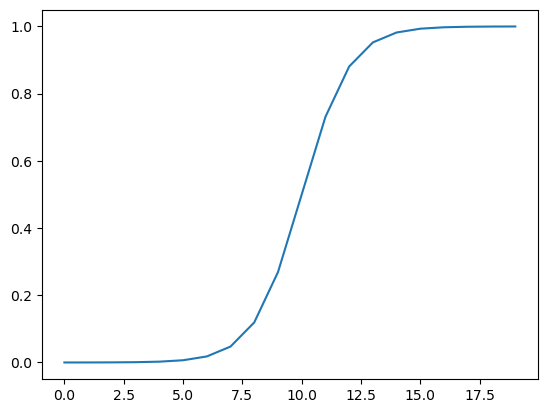

In [86]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification - classifying something into one of two classes
* Multi-class classification - classifying something into one of many classes

### 8.1 Creating multi-class data

In [126]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

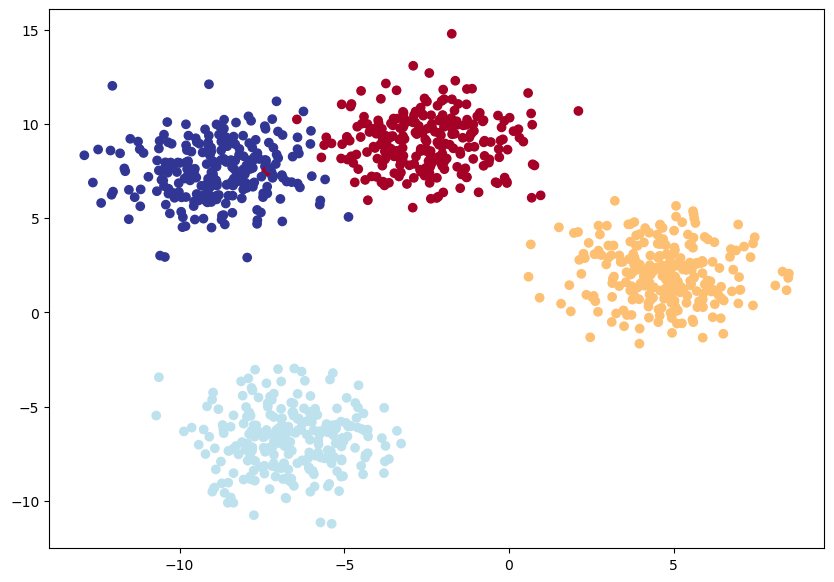

In [127]:
# Set Hyperparams for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split data into training and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], 
            X_blob[:, 1], 
            c=y_blob, 
            cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model

In [128]:
X_blob_train.shape, torch.unique(y_blob_train)

(torch.Size([800, 2]), tensor([0, 1, 2, 3]))

In [129]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Build a multi-class classification model
class BlobModel(nn.Module):
    """Initializes a multi-class classification model.
    
    Args:
        input_features (int): the number of input features
        output_features (int): the number of output features (number of classes)
        hidden_units (int): the number of hidden units in the model, default 8

    Returns:

    """
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Instantiate the model
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

### 8.3 Create Loss and Optimizer for Multi-class classification

In [130]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) into prediction probabilities and then to prediction labels.

Logits(aka raw model outputs) -> softmax -> prediction probabilities -> prediction labels (argmax)

In [131]:
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [132]:
# Let's get some raw outputs of our model
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_train)
    print(f"Raw model outputs: {y_logits[:5]}")

Raw model outputs: tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]])


In [133]:
# Convert our raw model outputs (logits) to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(f"Raw outputs: {y_logits[:5]}")
print(f"Prediction probabilities: {y_pred_probs[:5]}")

Raw outputs: tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]])
Prediction probabilities: tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]])


In [134]:
print(y_pred_probs[0])
print(torch.sum(y_pred_probs[0]))
print(torch.max(y_pred_probs[0]))
print(torch.argmax(y_pred_probs[0]))

tensor([0.3080, 0.3328, 0.1441, 0.2150])
tensor(1.)
tensor(0.3328)
tensor(1)


In [135]:
# Convert our model's prediction probabilities to predicted labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([1, 0, 0, 0, 0])

### 8.5 Create a training and testing loop for a multi-class model

In [136]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Build training loop
for epoch in range(epochs):
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    
    loss = loss_fn(y_logits,
                   y_blob_train)
    acc = accuracy_fn(y_blob_train,
                    y_preds)

    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()

    # Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
        test_loss = loss_fn(test_logits,
                            y_blob_test)
        test_acc = accuracy_fn(y_blob_test,
                               test_preds)

    # Print some results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Training Loss: {loss:.5f} | Training Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Training Loss: 1.15883 | Training Accuracy: 40.38% | Test Loss: 1.07554 | Test Accuracy: 48.00%
Epoch: 10 | Training Loss: 0.64476 | Training Accuracy: 96.75% | Test Loss: 0.66069 | Test Accuracy: 97.50%
Epoch: 20 | Training Loss: 0.42535 | Training Accuracy: 98.50% | Test Loss: 0.43074 | Test Accuracy: 100.00%
Epoch: 30 | Training Loss: 0.25294 | Training Accuracy: 99.12% | Test Loss: 0.24508 | Test Accuracy: 99.50%
Epoch: 40 | Training Loss: 0.11232 | Training Accuracy: 99.25% | Test Loss: 0.10229 | Test Accuracy: 99.50%
Epoch: 50 | Training Loss: 0.06627 | Training Accuracy: 99.25% | Test Loss: 0.05848 | Test Accuracy: 99.50%
Epoch: 60 | Training Loss: 0.05068 | Training Accuracy: 99.25% | Test Loss: 0.04293 | Test Accuracy: 99.50%
Epoch: 70 | Training Loss: 0.04300 | Training Accuracy: 99.25% | Test Loss: 0.03491 | Test Accuracy: 99.50%
Epoch: 80 | Training Loss: 0.03836 | Training Accuracy: 99.25% | Test Loss: 0.02988 | Test Accuracy: 99.50%
Epoch: 90 | Training Loss: 0

### 8.6 Test and Visualize the multi-class model

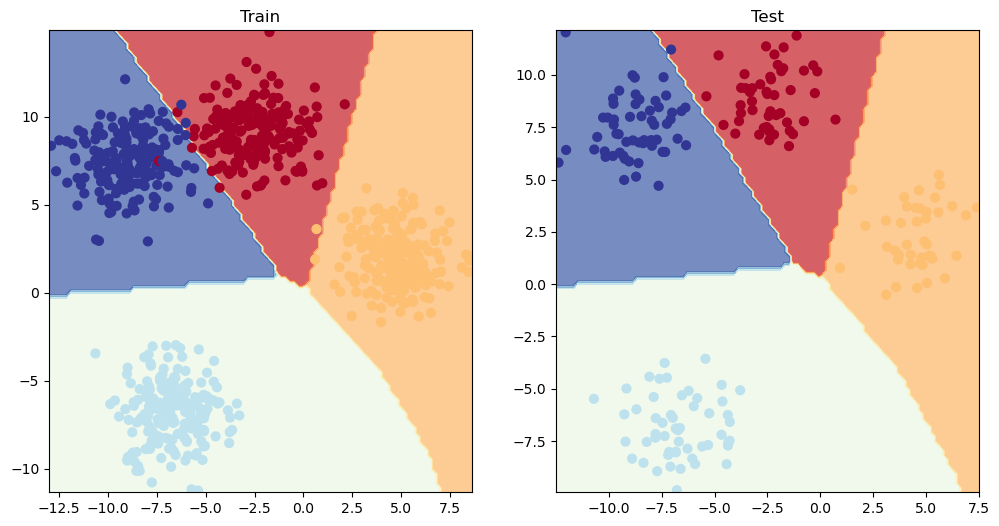

In [138]:
model_4.eval()
with torch.inference_mode():
    y_preds = torch.argmax(model_4(X_blob_test), dim=1)

# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_4,
                        X=X_blob_train,
                        y=y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_4,
                        X=X_blob_test,
                        y=y_blob_test)

## 9. A few more classification metrics (to evaluate our model)

* Accuracy
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [147]:
!pip install torchmetrics

  Obtaining dependency information for torchmetrics from https://files.pythonhosted.org/packages/db/c5/0b2ba92269328e58c9e33a70daa46d1f68212bda129c54343575780de752/torchmetrics-1.3.0.post0-py3-none-any.whl.metadata
  Obtaining dependency information for lightning-utilities>=0.8.0 from https://files.pythonhosted.org/packages/7d/84/fce34a549e2f795b3a0427e7dd40719dd4f00036e50ba58198a5a706eb75/lightning_utilities-0.10.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.3 MB/s eta 0:00:00a 0:00:01


In [149]:
import torchmetrics
from torchmetrics import Accuracy


In [154]:
torchmetric_accuracy = Accuracy(task="MULTICLASS", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_blob_test, y_preds)


tensor(0.9950)